In [1]:
import copy
import logging
from pathlib import Path
import shutil

import amici
from amici.petab_import import import_petab_problem
from amici.plotting import plotObservableTrajectories
import matplotlib.pyplot as plt
from more_itertools import one
import numpy as np
import pandas as pd
import petab
from petab.C import (
    TIME,
    ESTIMATE,
    MEASUREMENT,
    NOMINAL_VALUE,
)
import yaml2sbml

# Optimization
import pypesto.engine
import pypesto.objective
import pypesto.optimize
import pypesto.petab
import pypesto.visualize

# Optimal control
import petab_control
import petab_control.problem
from petab_control.constants import (
    CONTROL_TIMECOURSE_ID,
    PERIODS_RESULTS,
)
from petab_control.problem import (
    LLH,
    SLLH,
    get_control_petab_problem,
)

# Timecourse
import petab_timecourse
from petab_timecourse import Timecourse

# Helpers
def plot(
    rdata,
    model,
    estimate_petab_problem,
    control_petab_problem = None,
):
    fig, ax = plt.subplots()
    ax.scatter(
        estimate_petab_problem.measurement_df[petab.C.TIME],
        estimate_petab_problem.measurement_df[petab.C.MEASUREMENT],
        label='Real measurements for fitting.',
        color='blue',
    )

    if control_petab_problem is not None:
        ax.scatter(
            control_petab_problem.measurement_df[petab.C.TIME],
            control_petab_problem.measurement_df[petab.C.MEASUREMENT],
            label='Target measurements for control.',
            color='orange',
        )

    plotObservableTrajectories(rdata, model=model, ax=ax)
    ax.axvspan(0, 20, facecolor='blue', alpha=0.1)
    ax.axvspan(20, 100, facecolor='orange', alpha=0.1)
    ax.set_ylim(0,1)
    return ax, rdata

# Plotted time
end_time = 100


# The same optimizer, optimization engine, and number of starts is
# used for both estimation and optimal control, for this toy model.
optimizer = pypesto.optimize.FidesOptimizer(verbose=logging.WARNING)
#engine = pypesto.engine.MultiProcessEngine()
engine = pypesto.engine.SingleCoreEngine()

n_starts = 8

In [2]:
# Setup PEtab problem
input_path = Path('input') / 'bertozzi_control'
output_path = Path('output') / 'bertozzi_control'
petab_output_path = output_path / 'petab'
petab_output_path.mkdir(parents=True, exist_ok=True)

#if not petab_output_path.exists():
if True:
    shutil.rmtree(petab_output_path)
    shutil.copytree(input_path / 'petab', petab_output_path)
    #yaml2sbml.yaml2sbml(
    #    str(input_path / 'model.yaml'),
    #    str(petab_output_path / 'estimate' / 'model.xml'),
    #)

estimate_petab_problem = petab_timecourse.Problem.from_yaml(
    petab_output_path / 'estimate' / 'Bertozzi_PNAS2020.yaml',
    timecourse_file=petab_output_path / 'estimate' / 'timecourse.tsv',
)

# Optimize estimate problem to estimate patient-specific parameters
## Setup
model_output_path = output_path / 'models'
estimate_model_output_path = model_output_path / 'estimate'

In [3]:
# Setup PEtab control problem
control_petab_output_path = output_path / 'control_petab'
control_petab_output_path.mkdir(parents=True, exist_ok=True)

control_problem = petab_control.Problem.from_yaml(
    yaml_path=input_path / 'petab' / 'control' / 'petab_control_problem.yaml',
)

In [4]:
control_petab_problem = get_control_petab_problem(
    petab_control_problem=control_problem,
    petab_problem=estimate_petab_problem,
    timecourse_id='timecourse1',
)

In [5]:
from petab_timecourse.amici import collect_x, collect_sx, collect_y, collect_sy, collect_t, remove_duplicates

from petab_timecourse.simulator import AmiciSimulator

model_settings = {
    'setAlwaysCheckFinite': True,
}

solver_settings = {
    'setAbsoluteTolerance': 1e-8,
    'setRelativeTolerance': 1e-6,
    'setSensitivityOrder': amici.SensitivityOrder.first,
    'setSensitivityMethod': amici.SensitivityMethod.forward,
}

"""
estimated_parameters = {
    'decay': 0.010658565449186457,
    'substrate0': 0.8109781420306815,
}

# FIXME use result from optimizing original problem
estimated_parameters = {
    'decay': 1.0,
    'substrate0': 0.8109781420306815,
}
"""

"""
scaled_estimated_parameters = {
    'gamma_': 1.8727621566082335,
    'beta_': 1.8732304383810467,
    'mortality': -1.3537513788491515,
    'initial_Infected': 0.817831251725944,
    'initial_Recovered': -0.35745009184209914,
    'initial_Susceptible': 7.919078092376074,
}
estimated_parameters = estimate_petab_problem.unscale_parameters(scaled_estimated_parameters)
"""
estimated_parameters = {
    #'gamma_': 74.60400741968883,
    #'beta_': 74.68449321893274,
    'gamma_': 0.2,
    'beta_': 0.35,
    'mortality': 0.044284181406532674,
    'initial_Infected': 6.574023492670065,
    'initial_Recovered': 0.43908632156722666,
    'initial_Susceptible': 82999999.99999997,
}

default_problem_parameters = {
    #**estimated_parameters,
    'intervention': 0.0,
}
print(default_problem_parameters)

{'intervention': 0.0}


In [6]:
estimated_petab_problem = copy.deepcopy(estimate_petab_problem)
estimated_petab_problem.parameter_df[ESTIMATE] = 0

setup_simulator_kwargs = {
    'simulator_class': AmiciSimulator,
    'petab_problem': estimate_petab_problem,
    'timecourse_id': 'timecourse1',
    'default_problem_parameters': default_problem_parameters,
    'model_settings': model_settings,
    'solver_settings': solver_settings,
    'fix_petab_problem_parameters': estimated_parameters,
}

control_model_output_path = model_output_path / 'control'

petab_importer_kwargs = {
    'output_folder': str(control_model_output_path),
    'validate_petab': False,
}

create_problem_kwargs = {
    'copy_objective': False,
}

In [7]:
Timecourse.from_df(
    timecourse_df=estimate_petab_problem.timecourse_df,
    timecourse_id='timecourse1',
).periods

In [8]:
pypesto_problem = petab_control.objective.get_pypesto_problem(
    petab_control_problem=control_problem,
    setup_simulator_kwargs=setup_simulator_kwargs,
    #fix_simulator_parameters_kwargs=fix_simulator_parameters_kwargs,
    petab_importer_kwargs=petab_importer_kwargs,
)

2022-06-22 15:52:36.357 - amici.petab_import - INFO - Importing model ...
2022-06-22 15:52:36.363 - amici.petab_import - INFO - Model name is 'Bertozzi2020___generic__control_petab_problem'.
Writing model code to '/home/dilan/Documents/future_annex/optimal_control/packages/petab_control/doc/examples/amici_models/Bertozzi2020___generic__control_petab_problem'.
2022-06-22 15:52:36.365 - amici.petab_import - INFO - Species: 3
2022-06-22 15:52:36.366 - amici.petab_import - INFO - Global parameters: 3
2022-06-22 15:52:36.367 - amici.petab_import - INFO - Reactions: 2
2022-06-22 15:52:36.398 - amici.petab_import - INFO - Observables: 2
2022-06-22 15:52:36.399 - amici.petab_import - INFO - Sigmas: 2
2022-06-22 15:52:36.405 - amici.petab_import - DEBUG - Adding output parameters to model: OrderedDict()
2022-06-22 15:52:36.408 - amici.petab_import - DEBUG - Adding preequilibration indicator constant preequilibration_indicator
2022-06-22 15:52:36.411 - amici.petab_import - DEBUG - Adding initial

2022-06-22 15:52:37.696 - amici.ode_export - INFO - Finished running smart_jacobian           +++++ (9.08E-04s)
2022-06-22 15:52:37.704 - amici.ode_export - INFO - Finished simplifying dydx                 +++++ (2.53E-04s)
2022-06-22 15:52:37.706 - amici.ode_export - INFO - Finished computing dydx                    ++++ (1.93E-02s)
2022-06-22 15:52:37.728 - amici.ode_export - INFO - Finished running smart_jacobian           +++++ (5.97E-04s)
2022-06-22 15:52:37.743 - amici.ode_export - INFO - Finished simplifying dydw                 +++++ (2.10E-04s)
2022-06-22 15:52:37.746 - amici.ode_export - INFO - Finished computing dydw                    ++++ (3.09E-02s)
2022-06-22 15:52:37.766 - amici.ode_export - INFO - Finished simplifying dydx                  ++++ (4.31E-04s)
2022-06-22 15:52:37.772 - amici.ode_export - INFO - Finished computing dydx                     +++ (9.28E-02s)
2022-06-22 15:52:37.780 - amici.ode_export - INFO - Finished writing dydx.cpp                    ++ (1.0

2022-06-22 15:52:38.414 - amici.ode_export - INFO - Finished generating cpp code                  + (1.43E+00s)
2022-06-22 15:53:01.416 - amici.ode_export - INFO - Finished compiling cpp code                   + (2.30E+01s)
2022-06-22 15:53:01.418 - amici.petab_import - INFO - Finished Importing PEtab model                (2.51E+01s)
2022-06-22 15:53:01.422 - amici.petab_import - INFO - Successfully loaded model Bertozzi2020___generic__control_petab_problem from /home/dilan/Documents/future_annex/optimal_control/packages/petab_control/doc/examples/amici_models/Bertozzi2020___generic__control_petab_problem.


running AmiciInstall
Adding OpenMP flags...
hdf5.h found in /usr/include/hdf5/serial
libhdf5.a found in /usr/lib/x86_64-linux-gnu/hdf5/serial
running build_ext
Changed extra_compile_args for unix to ['-fopenmp', '-std=c++14']
Building model extension in /home/dilan/Documents/future_annex/optimal_control/packages/petab_control/doc/examples/amici_models/Bertozzi2020___generic__control_petab_problem
building 'Bertozzi2020___generic__control_petab_problem._Bertozzi2020___generic__control_petab_problem' extension
Testing SWIG executable swig4.0... SUCCEEDED.
swigging swig/Bertozzi2020___generic__control_petab_problem.i to swig/Bertozzi2020___generic__control_petab_problem_wrap.cpp
swig4.0 -python -c++ -modern -outdir Bertozzi2020___generic__control_petab_problem -I/home/dilan/Documents/future_annex/optimal_control/packages/AMICI/python/sdist/amici/swig -I/home/dilan/Documents/future_annex/optimal_control/packages/AMICI/python/sdist/amici/include -o swig/Bertozzi2020___generic__control_petab

In [9]:
history_options = pypesto.objective.HistoryOptions(
    trace_record=True,
)

pypesto_result = pypesto.optimize.minimize(
    problem=pypesto_problem,
    n_starts=10,
    optimizer=optimizer,
    history_options=history_options,
    filename=None,
)

  0%|          | 0/10 [00:00<?, ?it/s]WARNING:root:Fides is using BFGS as hessian approximation, as the problem does not provide a Hessian. Specify a Hessian to use a more efficient hybrid approximation scheme.
2022-06-22 15:53:03 fides(WARNING) Stopping as function difference 3.45E+01 was smaller than specified tolerances (atol=1.00E-08, rtol=1.00E-08)
 10%|█         | 1/10 [00:02<00:20,  2.24s/it]WARNING:root:Fides is using BFGS as hessian approximation, as the problem does not provide a Hessian. Specify a Hessian to use a more efficient hybrid approximation scheme.
2022-06-22 15:53:05 fides(WARNING) Stopping as function difference 3.21E+00 was smaller than specified tolerances (atol=1.00E-08, rtol=1.00E-08)
 20%|██        | 2/10 [00:03<00:13,  1.67s/it]WARNING:root:Fides is using BFGS as hessian approximation, as the problem does not provide a Hessian. Specify a Hessian to use a more efficient hybrid approximation scheme.
2022-06-22 15:53:07 fides(WARNING) Stopping as function diffe

In [10]:
pypesto_result.optimize_result.list[0]

{'id': '1',
 'x': array([-0.69897   , -0.45593196, -1.35375138,  0.81783125, -0.35745009,
         7.91907809,  0.        , -2.        , -2.        ,  0.        ,
        -0.18326308]),
 'fval': 3938119404.7982397,
 'grad': array([            nan,             nan,             nan,             nan,
                    nan,             nan,             nan,  3.27620499e+08,
         1.16515142e+05,             nan, -5.00255053e+01]),
 'hess': array([[            nan,             nan,             nan,
                     nan,             nan,             nan,
                     nan,             nan,             nan,
                     nan,             nan],
        [            nan,             nan,             nan,
                     nan,             nan,             nan,
                     nan,             nan,             nan,
                     nan,             nan],
        [            nan,             nan,             nan,
                     nan,             nan,      

In [11]:
scaled_optimum = dict(zip(pypesto_problem.x_names, pypesto_result.optimize_result.list[0].x))
unscaled_optimum = control_problem.optimizer_control_petab_problem.unscale_parameters(scaled_optimum)

In [12]:
problem_parameters = {
    **default_problem_parameters,
    **unscaled_optimum,
}

In [13]:
problem_parameters = {
    **default_problem_parameters,
    **scaled_optimum,
}

In [14]:
results = control_problem.simulate(problem_parameters=problem_parameters)

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(



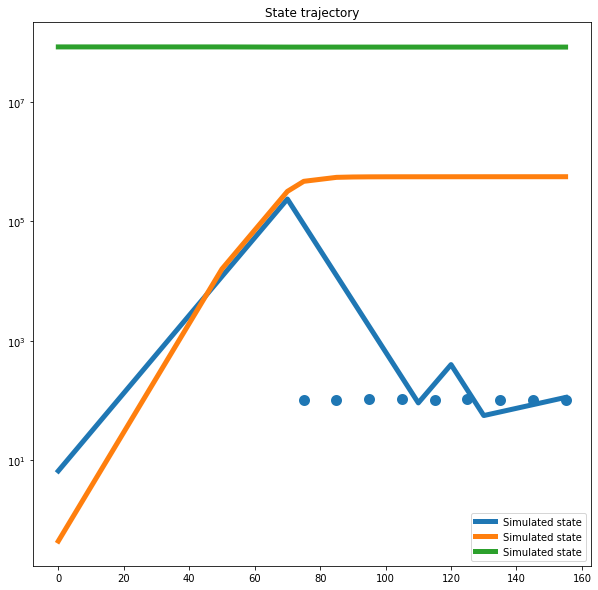

In [15]:
x_ = collect_x(results[PERIODS_RESULTS])
sx_ = collect_sx(results[PERIODS_RESULTS])
t_ = collect_t(results[PERIODS_RESULTS])

T, X, SX = remove_duplicates(t_, x_, sx_)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(T, X, lw=5, label='Simulated state')
ax.legend()
ax.set_title('State trajectory')

mT = control_problem.simulator.petab_problem.measurement_df[TIME]
mX = control_problem.simulator.petab_problem.measurement_df[MEASUREMENT]

ax.set_yscale('log')

ax.scatter(mT, mX, lw=5, label='Measured state')

In [16]:
from petab_timecourse.amici import add_output_timepoints_if_missing
if True:
    # Fake timepoints for more simulation output
    for edata, period in zip(
        control_problem.simulator.amici_edata_periods,
        control_problem.simulator.timecourse.periods,
    ):
        current_timepoints = edata.getTimepoints()
        add_output_timepoints_if_missing(
            amici_edata=edata,
            timepoints=np.linspace(current_timepoints[0], current_timepoints[-1], 1001)
        )

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(



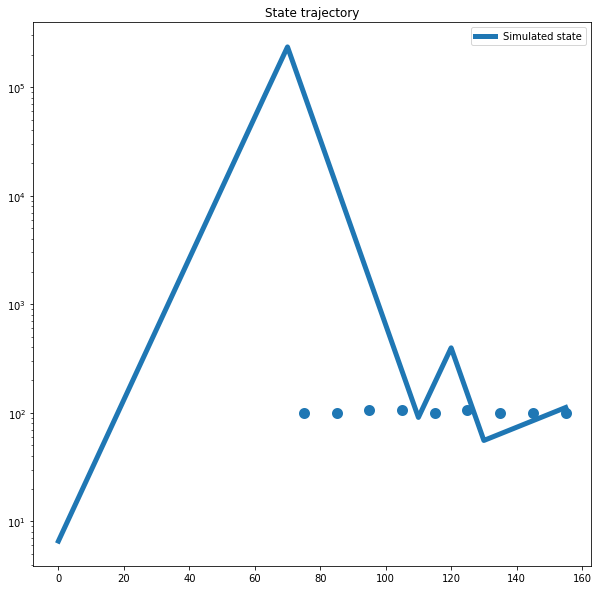

In [17]:
results = control_problem.simulate(problem_parameters=problem_parameters)

x_ = collect_x(results[PERIODS_RESULTS])
sx_ = collect_sx(results[PERIODS_RESULTS])
t_ = collect_t(results[PERIODS_RESULTS])

T, X, SX = remove_duplicates(t_, x_, sx_)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(T, X[:, 0], lw=5, label='Simulated state')
ax.legend()
ax.set_title('State trajectory')

mT = control_problem.simulator.petab_problem.measurement_df[TIME]
mX = control_problem.simulator.petab_problem.measurement_df[MEASUREMENT]

ax.set_yscale('log')

ax.scatter(mT, mX, lw=5, label='Measured state (?)')

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(

  warnings.warn(



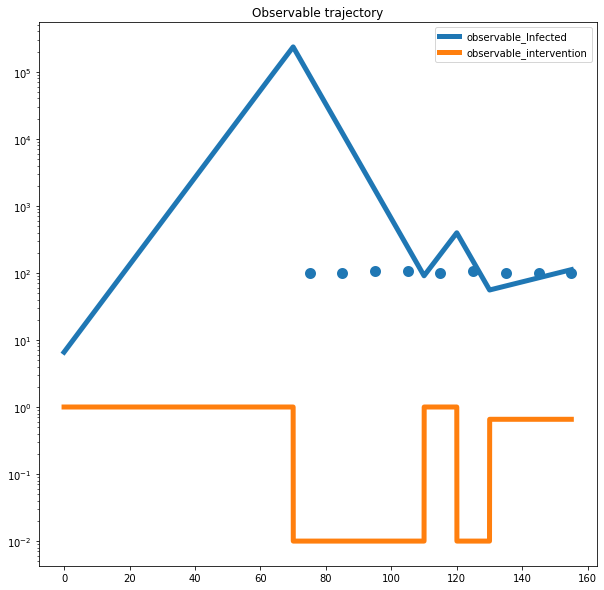

In [18]:
results = control_problem.simulate(problem_parameters=problem_parameters)

y_ = collect_y(results[PERIODS_RESULTS])
sy_ = collect_sy(results[PERIODS_RESULTS])
t_ = collect_t(results[PERIODS_RESULTS])

T, Y, SY = remove_duplicates(t_, y_, sy_)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(T, Y, lw=5, label=control_problem.objective_observable_df.index)
ax.legend()
ax.set_title('Observable trajectory')

mT = control_problem.simulator.petab_problem.measurement_df[TIME]
mX = control_problem.simulator.petab_problem.measurement_df[MEASUREMENT]

#ax.set_xscale('log')
ax.set_yscale('log')

#ax.set_xlim([115,120])

ax.scatter(mT, mX, lw=5, label='Measured observable')

In [19]:
_y0 = None
for _t, _y in zip(T, Y[:, 1]):
    if _y == _y0:
        continue
    _y0 = _y
    print(f'{_t:.2f}\t{_y:.5f}')

0.00	1.00000
70.02	0.01000
90.01	0.01000
110.01	1.00000
120.01	0.01000
130.03	0.65575


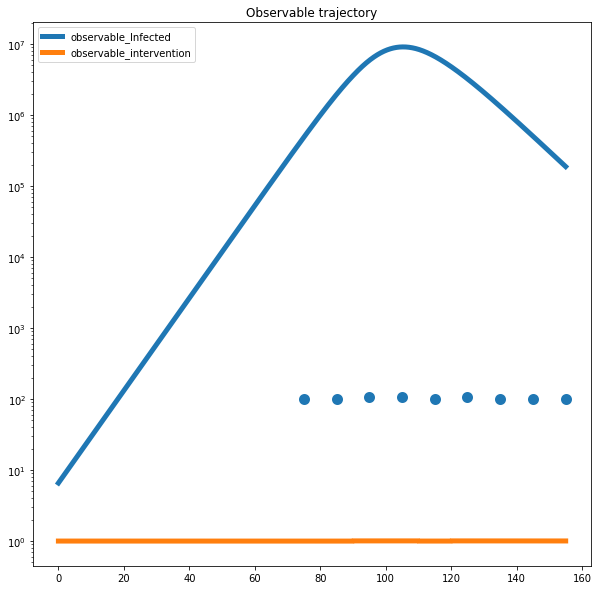

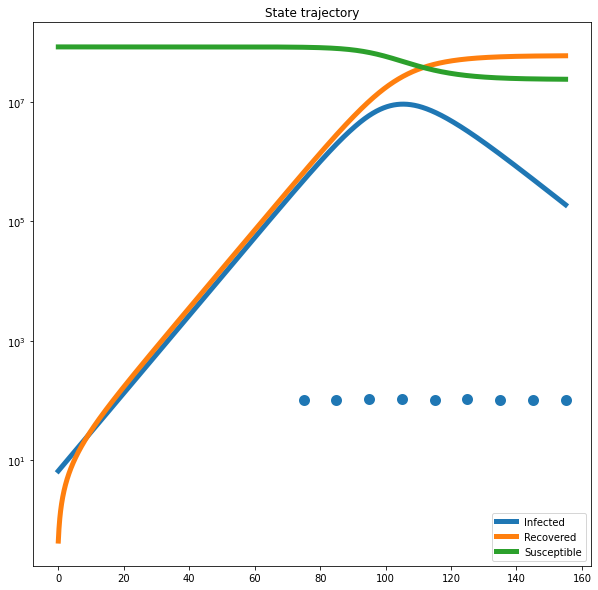

In [20]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    results = control_problem.simulate(problem_parameters=
{'intervention': 0.0,
 #'gamma_': 1.8727621566082335,
 'beta_': 1.8732304383810467,
 'gamma_': 0.0,
 #'beta_': 0.6,
 'mortality': -1.3537513788491515,
 'initial_Infected': 0.817831251725944,
 'initial_Recovered': -0.35745009184209914,
 'initial_Susceptible': 7.919078092376074,
 'intervention_00': 0.0,
 'intervention_20': -0.00047033502812480994,
 #'intervention_20': 0.0022280024742958276,
 'intervention_40': 0.0022280024742958276,
 'intervention_60': 0.0,
 'intervention_80': 0.0013676505148725315}
)

x_ = collect_x(results[PERIODS_RESULTS])
sx_ = collect_sx(results[PERIODS_RESULTS])
y_ = collect_y(results[PERIODS_RESULTS])
sy_ = collect_sy(results[PERIODS_RESULTS])
t_ = collect_t(results[PERIODS_RESULTS])

T, X, SX, Y, SY = remove_duplicates(t_, x_, sx_, y_, sy_)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(T, Y, lw=5, label=control_problem.objective_observable_df.index)
ax.legend()
ax.set_title('Observable trajectory')

mT = control_problem.simulator.petab_problem.measurement_df[TIME]
mX = control_problem.simulator.petab_problem.measurement_df[MEASUREMENT]

#ax.set_xscale('log')
ax.set_yscale('log')

#ax.set_xlim([115,120])

ax.scatter(mT, mX, lw=5, label='Measured observable');

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(T, X, lw=5, label=control_problem.simulator.amici_model.getStateIds())
ax.legend()
ax.set_title('State trajectory')

mT = control_problem.simulator.petab_problem.measurement_df[TIME]
mX = control_problem.simulator.petab_problem.measurement_df[MEASUREMENT]

#ax.set_xscale('log')
ax.set_yscale('log')

#ax.set_xlim([115,120])

ax.scatter(mT, mX, lw=5, label='States with observable measurements');

In [21]:
fix_petab_problem_parameters = {
    #'gamma_': 74.60400741968883,
    #'beta_': 74.68449321893274,
    'gamma_': 0.2,
    'beta_': 0.35,
    'mortality': 0.044284181406532674,
    'initial_Infected': 6.574023492670065,
    'initial_Recovered': 0.43908632156722666,
    'initial_Susceptible': 82999999.99999997,
}

setup_simulator_kwargs = {
    'simulator_class': AmiciSimulator,
    'petab_problem': estimate_petab_problem,
    'timecourse_id': 'timecourse1',
    'default_problem_parameters': default_problem_parameters,
    'model_settings': model_settings,
    'solver_settings': solver_settings,
    'fix_petab_problem_parameters': fix_petab_problem_parameters,
}

control_problem.setup_simulator(
    **setup_simulator_kwargs,
)

2022-06-22 15:53:22.898 - amici.petab_import - INFO - Successfully loaded model Bertozzi2020___generic__control_petab_problem from /home/dilan/Documents/future_annex/optimal_control/packages/petab_control/doc/examples/amici_models/Bertozzi2020___generic__control_petab_problem.
INFO:amici.petab_import:Successfully loaded model Bertozzi2020___generic__control_petab_problem from /home/dilan/Documents/future_annex/optimal_control/packages/petab_control/doc/examples/amici_models/Bertozzi2020___generic__control_petab_problem.


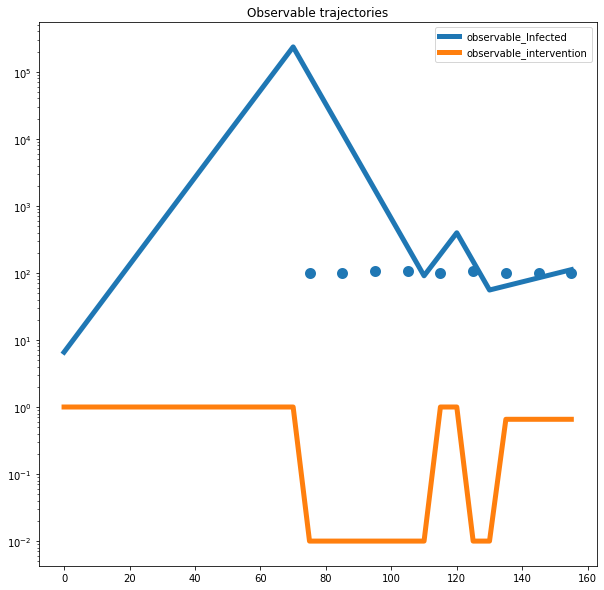

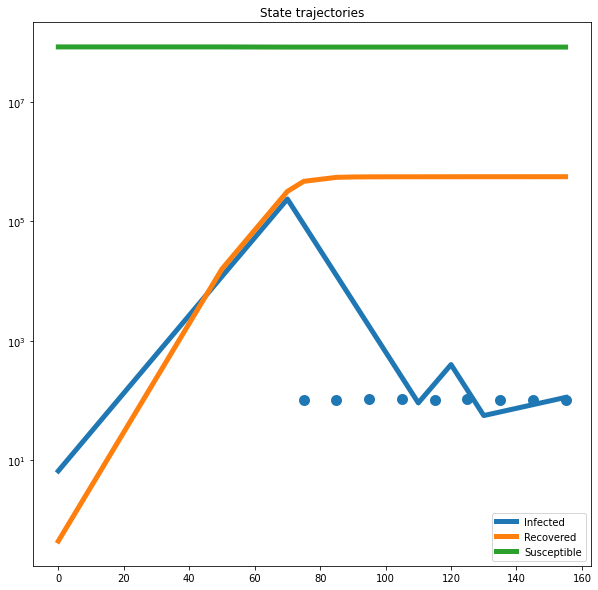

In [22]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    results = control_problem.simulate(problem_parameters=problem_parameters
)

x_ = collect_x(results[PERIODS_RESULTS])
sx_ = collect_sx(results[PERIODS_RESULTS])
y_ = collect_y(results[PERIODS_RESULTS])
sy_ = collect_sy(results[PERIODS_RESULTS])
t_ = collect_t(results[PERIODS_RESULTS])

T, X, SX, Y, SY = remove_duplicates(t_, x_, sx_, y_, sy_)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(T, Y, lw=5, label=control_problem.objective_observable_df.index)
ax.legend()
ax.set_title('Observable trajectories')

mT = control_problem.simulator.petab_problem.measurement_df[TIME]
mX = control_problem.simulator.petab_problem.measurement_df[MEASUREMENT]

#ax.set_xscale('log')
ax.set_yscale('log')

#ax.set_xlim([115,120])

ax.scatter(mT, mX, lw=5, label='Measurements of observable Infected');

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(T, X, lw=5, label=control_problem.simulator.amici_model.getStateIds())
ax.legend()
ax.set_title('State trajectories')

mT = control_problem.simulator.petab_problem.measurement_df[TIME]
mX = control_problem.simulator.petab_problem.measurement_df[MEASUREMENT]

#ax.set_xscale('log')
ax.set_yscale('log')

#ax.set_xlim([115,120])

ax.scatter(mT, mX, lw=5, label='Measurements of observable Infected');

In [23]:
pypesto_problem.objective.check_grad_multi_eps(x=[.1]*3)

             grad          fd_f          fd_b          fd_c        fd_err  \
x_0  4.875961e+14  8.235707e+14  2.394741e+14  5.315224e+14  5.840966e+14   
x_1  6.042520e+14  6.845689e+14  5.105750e+14  5.975720e+14  1.739939e+14   
x_2  3.759098e+10  4.876741e+10  3.031090e+10  3.953916e+10  1.845652e+10   

          abs_err   rel_err  
x_0  4.392626e+13  0.082642  
x_1  6.680050e+12  0.011179  
x_2  1.948178e+09  0.049272  
INFO:pypesto.objective.base:             grad          fd_f          fd_b          fd_c        fd_err  \
x_0  4.875961e+14  8.235707e+14  2.394741e+14  5.315224e+14  5.840966e+14   
x_1  6.042520e+14  6.845689e+14  5.105750e+14  5.975720e+14  1.739939e+14   
x_2  3.759098e+10  4.876741e+10  3.031090e+10  3.953916e+10  1.845652e+10   

          abs_err   rel_err  
x_0  4.392626e+13  0.082642  
x_1  6.680050e+12  0.011179  
x_2  1.948178e+09  0.049272  
             grad          fd_f          fd_b          fd_c        fd_err  \
x_0  4.875961e+14  3.543526e+14  3.50

,grad,fd_f,fd_b,fd_c,fd_err,abs_err,rel_err,eps
x_0,4.875961e+14,8.235707e+14,2.394741e+14,5.315224e+14,5.840966e+14,4.392626e+13,0.082642,0.10000
x_1,6.042520e+14,6.845689e+14,5.105750e+14,5.975720e+14,1.739939e+14,6.680050e+12,0.011179,0.10000
x_2,3.759098e+10,3.754783e+10,3.762581e+10,3.758682e+10,7.798438e+07,4.156399e+06,0.000111,0.00001


In [24]:
pypesto_problem.objective.check_grad_multi_eps(x=[.2]*3)

             grad          fd_f          fd_b          fd_c        fd_err  \
x_0  2.874436e+15  1.595541e+15  3.042158e+14  9.498785e+14  1.291325e+15   
x_1  1.803174e+14  1.920747e+14  1.652195e+14  1.786471e+14  2.685517e+13   
x_2  4.912118e+08  5.950822e+08  4.147565e+08  5.049193e+08  1.803258e+08   

          abs_err   rel_err  
x_0  1.924558e+15  2.026109  
x_1  1.670279e+12  0.009350  
x_2  1.370750e+07  0.027148  
INFO:pypesto.objective.base:             grad          fd_f          fd_b          fd_c        fd_err  \
x_0  2.874436e+15  1.595541e+15  3.042158e+14  9.498785e+14  1.291325e+15   
x_1  1.803174e+14  1.920747e+14  1.652195e+14  1.786471e+14  2.685517e+13   
x_2  4.912118e+08  5.950822e+08  4.147565e+08  5.049193e+08  1.803258e+08   

          abs_err   rel_err  
x_0  1.924558e+15  2.026109  
x_1  1.670279e+12  0.009350  
x_2  1.370750e+07  0.027148  
             grad          fd_f          fd_b          fd_c        fd_err  \
x_0  2.874436e+15  1.622276e+15  1.61

,grad,fd_f,fd_b,fd_c,fd_err,abs_err,rel_err,eps
x_0,2.874436e+15,1.624813e+15,1.623596e+15,1.624204e+15,1.217195e+12,1.250232e+15,0.769750,1.000000e-05
x_1,1.803174e+14,1.802189e+14,1.802150e+14,1.802170e+14,3.914375e+09,1.004282e+11,0.000557,1.000000e-07
x_2,4.912118e+08,4.911937e+08,4.911750e+08,4.911844e+08,1.875000e+04,2.746994e+04,0.000056,1.000000e-05


In [25]:
pypesto_problem.objective.check_grad_multi_eps(x=[.01]*3)

             grad          fd_f          fd_b          fd_c        fd_err  \
x_0  5.561655e+13  4.388422e+14  8.464190e+13  2.617420e+14  3.542003e+14   
x_1  6.308878e+14  6.772155e+14  4.303423e+14  5.537789e+14  2.468731e+14   
x_2  2.181672e+12  3.091884e+12  1.660133e+12  2.376008e+12  1.431752e+12   

          abs_err   rel_err  
x_0  2.061255e+14  0.787514  
x_1  7.710891e+13  0.139241  
x_2  1.943369e+11  0.081791  
INFO:pypesto.objective.base:             grad          fd_f          fd_b          fd_c        fd_err  \
x_0  5.561655e+13  4.388422e+14  8.464190e+13  2.617420e+14  3.542003e+14   
x_1  6.308878e+14  6.772155e+14  4.303423e+14  5.537789e+14  2.468731e+14   
x_2  2.181672e+12  3.091884e+12  1.660133e+12  2.376008e+12  1.431752e+12   

          abs_err   rel_err  
x_0  2.061255e+14  0.787514  
x_1  7.710891e+13  0.139241  
x_2  1.943369e+11  0.081791  
             grad          fd_f          fd_b          fd_c        fd_err  \
x_0  5.561655e+13  1.897492e+14  1.88

,grad,fd_f,fd_b,fd_c,fd_err,abs_err,rel_err,eps
x_0,5.561655e+13,1.908919e+14,1.875643e+14,1.892281e+14,3.327534e+12,1.336115e+14,7.060873e-01,1.000000e-03
x_1,6.308878e+14,5.639727e+14,5.640557e+14,5.640142e+14,8.303125e+10,6.687363e+13,1.185673e-01,1.000000e-09
x_2,2.181672e+12,2.188334e+12,2.175014e+12,2.181674e+12,1.331982e+10,2.028657e+06,9.298628e-07,1.000000e-03


In [26]:
pypesto_result.optimize_result.list[0].x

array([-0.69897   , -0.45593196, -1.35375138,  0.81783125, -0.35745009,
        7.91907809,  0.        , -2.        , -2.        ,  0.        ,
       -0.18326308])

In [27]:
dict(zip(pypesto_problem.x_names, pypesto_result.optimize_result.list[0].x))

{'gamma_': -0.6989700043360187,
 'beta_': -0.4559319556497244,
 'mortality': -1.3537513788491515,
 'initial_Infected': 0.817831251725944,
 'initial_Recovered': -0.35745009184209914,
 'initial_Susceptible': 7.919078092376074,
 'intervention_00': 0.0,
 'intervention_20': -2.0,
 'intervention_40': -1.9999999984856411,
 'intervention_60': 0.0,
 'intervention_80': -0.1832630768380033}

In [28]:
pypesto_problem.objective.check_grad_multi_eps(x=[-2, -2, -0.18])

             grad          fd_f          fd_b          fd_c        fd_err  \
x_0  3.276205e+08  3.707314e+08  2.919341e+08  3.313327e+08  7.879727e+07   
x_1  1.165151e+05  1.354196e+05  1.062658e+05  1.208427e+05  2.915373e+04   
x_2  9.557898e+03  9.195036e+05 -4.112887e+04  4.391873e+05  9.606324e+05   

          abs_err   rel_err  
x_0  3.712234e+06  0.011204  
x_1  4.327562e+03  0.035811  
x_2  4.296295e+05  0.978237  
INFO:pypesto.objective.base:             grad          fd_f          fd_b          fd_c        fd_err  \
x_0  3.276205e+08  3.707314e+08  2.919341e+08  3.313327e+08  7.879727e+07   
x_1  1.165151e+05  1.354196e+05  1.062658e+05  1.208427e+05  2.915373e+04   
x_2  9.557898e+03  9.195036e+05 -4.112887e+04  4.391873e+05  9.606324e+05   

          abs_err   rel_err  
x_0  3.712234e+06  0.011204  
x_1  4.327562e+03  0.035811  
x_2  4.296295e+05  0.978237  
             grad          fd_f          fd_b          fd_c        fd_err  \
x_0  3.276205e+08  2.500691e+08  3.40

,grad,fd_f,fd_b,fd_c,fd_err,abs_err,rel_err,eps
x_0,3.276205e+08,3.273954e+08,3.287262e+08,3.280608e+08,1.330862e+06,440312.807262,0.001342,1.000000e-03
x_1,1.165151e+05,1.195478e+05,1.195526e+05,1.195502e+05,4.768372e+00,3035.086250,0.025388,1.000000e-07
x_2,9.557898e+03,9.565401e+03,9.553146e+03,9.559274e+03,1.225471e+01,1.376121,0.000144,1.000000e-05
